In [1]:
%pip install transformers datasets -q

In [46]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/conreteness_ratings')

  0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
ds['train'].features

{'Word': Value(dtype='string', id=None),
 'Bigram': Value(dtype='int64', id=None),
 'Conc.M': Value(dtype='float64', id=None),
 'Conc.SD': Value(dtype='float64', id=None),
 'Unknown': Value(dtype='int64', id=None),
 'Total': Value(dtype='int64', id=None),
 'Percent_known': Value(dtype='float64', id=None),
 'SUBTLEX': Value(dtype='int64', id=None)}

In [48]:
ds = ds.rename_column('Conc.M', 'avg_concreteness')

In [49]:
ds['train'][100]

{'Word': 'absorbable',
 'Bigram': 0,
 'avg_concreteness': 2.47,
 'Conc.SD': 1.36,
 'Unknown': 0,
 'Total': 30,
 'Percent_known': 1.0,
 'SUBTLEX': 0}

In [50]:
from sklearn.preprocessing import MinMaxScaler
from datasets import Dataset 

scaler = MinMaxScaler()

processing_ds = ds['train'].to_pandas()

processing_ds['avg_concreteness'] = scaler.fit_transform(processing_ds['avg_concreteness'].to_numpy().reshape(-1, 1))

ds['train'] = Dataset.from_pandas(processing_ds)

In [58]:
import numpy as np
np.array(ds['train']['avg_concreteness']).max(), np.array(ds['train']['avg_concreteness']).min()

(1.0, 0.0)

<Axes: >

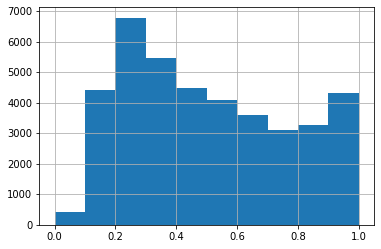

In [59]:
ds['train'].to_pandas()['avg_concreteness'].hist()

In [60]:
ds['train'].to_pandas()['avg_concreteness'].describe()

count    39954.000000
mean         0.504108
std          0.262273
min          0.000000
25%          0.272727
50%          0.464646
75%          0.719697
max          1.000000
Name: avg_concreteness, dtype: float64

In [61]:
ds = ds.remove_columns(['Conc.SD', 'Unknown', 'Total', 'SUBTLEX', 'Percent_known', 'Bigram'])

In [62]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(batch):
    # max_length as suggested by the paper
    return tokenizer(batch['Word'], padding='max_length', truncation=True, max_length=10)

In [63]:
ds = ds.filter(lambda x: x['Word'] is not None)

Filter:   0%|          | 0/39954 [00:00<?, ? examples/s]

In [64]:
tokenized_ds = ds.map(tokenize, batched=True)

Map:   0%|          | 0/39953 [00:00<?, ? examples/s]

In [65]:
tokenized_ds = tokenized_ds.rename_column('avg_concreteness', 'labels')

In [66]:
tokenized_ds = tokenized_ds['train'].train_test_split(test_size=0.1, shuffle=True)

In [67]:
tokenized_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [68]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_ds['train'], batch_size=8)
test_loader = DataLoader(tokenized_ds['test'], batch_size=8)

In [69]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [70]:
from torch.optim import Adam

# suggested learning rate by the paper
optimizer = Adam(model.parameters(), lr=2e-5)

In [71]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = len(train_loader) * 3

lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [72]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [73]:
device

device(type='cuda')

In [74]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/13485 [00:00<?, ?it/s]

In [75]:
from scipy.stats import pearsonr

model.eval()

predictions = []
targets = []

for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions.extend(logits.squeeze().tolist())
    targets.extend(batch["labels"].squeeze().tolist())



corr_corf, p_value = pearsonr(predictions, targets)

print(f"Pearson Correlation Coefficient: {corr_corf:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson Correlation Coefficient: 0.9205
P-value: 0.0000


In [76]:
def predict(word):
    input_ids = tokenizer(word, return_tensors='pt').input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits
    return logits.item()

In [82]:
predict('abstract'), predict('novelty'), predict('dog'), predict('cat')

(0.1439209133386612, 0.299909770488739, 0.9963857531547546, 1.0014569759368896)

In [83]:
model.save_pretrained('word_concreteness_model')

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [88]:
model.push_to_hub('martingrzzler/bert-word-conreteness', create_pr=1)

CommitInfo(commit_url='https://huggingface.co/martingrzzler/bert-word-conreteness/commit/8484a9db5460e3c3d2c6beda5d6152f7ae3f11a9', commit_message='Upload BertForSequenceClassification', commit_description='', oid='8484a9db5460e3c3d2c6beda5d6152f7ae3f11a9', pr_url='https://huggingface.co/martingrzzler/bert-word-conreteness/discussions/1', pr_revision='refs/pr/1', pr_num=1)